# ************ NOTEBOOK 3 :  MACHINE LEARNING*********** 

Dans ce notebook, nous allons essayer d'avoir un aperçu de notre  modèle à travers le package shap. Nous allons comprendre et expliquer les variables crédibles sélectionnés .

Le tracé le plus important est le tracé récapitulatif (ci-dessous dans ce cahier), qui montre les 20 variables indépendantes les plus importantes. Pour chaque variable, une distribution est tracée sur la façon dont les échantillons de données d'entrainement influencent le résultat du modèle. Plus les points sont rouges, plus la valeur de la feature est élevée, plus il y a de bleu, plus la valeur de la feature est faible.

Dans ce cas, l'entité EXT_SOURCE_2 est la variable qui a le plus d'impact sur la sortie du modèle. Les échantillons de données d'entrainement avec une faible EXT_SOURCE_2 ont une probabilité plus élevée lors de l'obtention d'un prêt. Si le client a une valeur EXT_SOURCE_2 élevée, la probabilité d'obtenir un prêt est faible. Pour la barre rouge à droite, on voit que beaucoup de clients sont dans ce cas.


# 1 Importation des librairies et jeux de données

In [1]:
import pandas as pd # package for high-performance, easy-to-use data structures and data analysis
import numpy as np # fundamental package for scientific computing with Python
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for making plots with seaborn
color = sns.color_palette()
import time, pickle
#Preprocessing, Upsampling, Model Selection, Model Evaluation
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, f1_score, precision_score, recall_score 
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.model_selection import cross_val_predict, cross_val_score, learning_curve, cross_validate
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_row',250)
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings("ignore")

# 2_Importation de la libaririe lightgbm 

In [2]:
#Predictive Models
from lightgbm import LGBMClassifier


 # 3_Fonctions utiles

In [3]:
def cf_matrix_roc_auc(model, y_true, y_pred, y_pred_proba):
    '''This function will make a pretty plot of 
  an sklearn Confusion Matrix using a Seaborn heatmap visualization + ROC Curve.'''
    fig = plt.figure(figsize=(20,15))
  
    plt.subplot(221)
    cf_matrix = confusion_matrix(y_true, y_pred)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

    plt.subplot(222)
    fpr,tpr,_ = roc_curve(y_true, y_pred_proba)
   # plt.plot(fpr, tpr, color='orange', linewidth=5, label='AUC = %0.4f' %roc_auc)
    plt.plot(fpr, tpr, color='orange', linewidth=5, label='AUC = %0.4f' %roc_auc )
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

# 4_Importation du jeux de données avec features les plus crédibles.

In [4]:
data=pd.read_csv('X_data.csv').set_index('SK_ID_CURR')

In [5]:
data.head()

,INSTA_DAYS_INSTALMENT,NAME_INCOME_TYPE_Working,NAME_INCOME_TYPE_Stateservant,CODE_GENDER_M,NAME_CONTRACT_TYPE_Revolvingloans,NAME_EDUCATION_TYPE_Incompletehigher,NAME_EDUCATION_TYPE_Lowersecondary,FLAG_PHONE,FLAG_WORK_PHONE,DAYS_ID_PUBLISH,DAYS_REGISTRATION,REGION_POPULATION_RELATIVE,NAME_EDUCATION_TYPE_Secondarysecondaryspecial,AMT_CREDIT,AMT_INCOME_TOTAL,CNT_CHILDREN,REGION_RATING_CLIENT,FLAG_DOCUMENT_18,FLAG_DOCUMENT_16,DEBT_CREDIT_RATIO,PREV_NFLAG_INSURED_ON_APPROVAL,PREV_AMT_CREDIT,PREV_APP_COUNT,OVERDUE_DEBT_RATIO,BUREAU_CREDIT_TYPE_Mortgage,BUREAU_CREDIT_TYPE_Microloan,PREV_AMT_DOWN_PAYMENT,PREV_RATE_DOWN_PAYMENT,PREV_DAYS_TERMINATION,FLAG_DOCUMENT_13,PREV_DAYS_LAST_DUE_1ST_VERSION,PREV_DAYS_FIRST_DRAWING,PREV_CNT_PAYMENT,PREV_SELLERPLACE_AREA,OCCUPATION_TYPE_Corestaff,OCCUPATION_TYPE_LowskillLaborers,ORGANIZATION_TYPE_BusinessEntityType3,ORGANIZATION_TYPE_Military,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_Salesstaff,OCCUPATION_TYPE_Laborers,HOUR_APPR_PROCESS_START,NAME_FAMILY_STATUS_Singlenotmarried,NAME_FAMILY_STATUS_Married,FLAG_DOCUMENT_3,ORGANIZATION_TYPE_Construction,REG_CITY_NOT_LIVE_CITY,INSTA_NUM_INSTALMENT_VERSION,BUREAU_CREDIT_ACTIVE_Active,BUREAU_AMT_CREDIT_SUM_DEBT,ORGANIZATION_TYPE_Selfemployed,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_School,BUREAU_AMT_CREDIT_SUM,BUREAU_CREDIT_CURRENCY_currency3,BUREAU_AMT_CREDIT_SUM_OVERDUE,BUREAU_AMT_CREDIT_SUM_LIMIT,Credit_as_percent_income,BUREAU_DAYS_CREDIT,BUREAU_DAYS_CREDIT_ENDDATE,BUREAU_AMT_CREDIT_MAX_OVERDUE,BUREAU_AMT_ANNUITY,BUREAU_CREDIT_TYPE_Carloan,CREDIT_NAME_CONTRACT_STATUS_Sentproposal,BUREAU_CREDIT_ACTIVE_Closed,BUREAU_CREDIT_ACTIVE_Sold,BUREAU_CREDIT_TYPE_Creditcard,BUREAU_CREDIT_TYPE_Consumercredit,ORGANIZATION_TYPE_Transporttype3,CREDIT_AMT_DRAWINGS_OTHER_CURRENT,CREDIT_CNT_DRAWINGS_ATM_CURRENT,CREDIT_CNT_DRAWINGS_OTHER_CURRENT,CREDIT_CNT_DRAWINGS_POS_CURRENT,CREDIT_SK_DPD,CREDIT_NAME_CONTRACT_STATUS_Completed,CREDIT_AMT_CREDIT_LIMIT_ACTUAL,WALLSMATERIAL_MODE_Panel,INSTA_AMT_PAYMENT,PREV_DAYS_FIRST_DUE,DAYS_LAST_PHONE_CHANGE,EXT_SOURCE_2,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,FLAG_OWN_CAR,EXT_SOURCE_3,Age,TARGET
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
285133,1973.000000,0,0,0,0,0,0,0,0,1823,7460.0,0.006852,0,1971072.0,405000.0,2,3,0,0,0.556408,0.000000,51034.500000,1.0,0.0,0.0,0.0,5175.00,0.100269,1805.000000,0,1808.000000,365243.0,12.0,86.000000,0,0,0,0,0,0,0,11,0,1,1,0,0,1.000000,0.500000,297855.000,1,0,0,535317.795,0.0,0.0,0.0,486.684444,846.75,51.000000,0.0,24156.0,0.25,0.0,0.500000,0.0,0.250000,0.500000,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,5914.278750,2138.000000,2169.0,0.327724,4.0,0.0,0.0,0.0,1.0,0.643026,37.2,0
191894,329.476190,0,1,1,0,0,0,0,0,1090,4054.0,0.010276,0,508495.5,337500.0,0,2,0,0,0.000000,0.666667,320013.000000,5.0,0.0,0.0,0.0,0.00,0.000000,243387.000000,0,121778.000000,365243.0,12.0,1.000000,0,0,0,0,0,0,0,11,0,1,0,0,0,1.047619,0.000000,0.000,0,0,0,0.000,0.0,0.0,0.0,150.665333,0.00,0.000000,0.0,0.0,0.00,0.0,0.000000,0.0,0.000000,0.000000,0,0.0,0.0,0.0,0.0,0.0,0.0,765000.0,0,46948.062857,121438.000000,659.0,0.617831,2.0,1.0,0.0,6.0,0.0,0.440058,48.1,0
369428,1344.666667,0,0,1,0,0,0,1,0,4130,5554.0,0.005084,1,110146.5,112500.0,1,2,0,0,0.000000,0.750000,234599.142857,7.0,0.0,0.0,0.0,11407.50,0.189604,745.250000,0,301.500000,365243.0,23.2,29.142857,0,0,1,0,0,0,1,11,0,1,0,0,0,1.238095,0.000000,0.000,0,0,0,0.000,0.0,0.0,0.0,97.908000,0.00,0.000000,0.0,0.0,0.00,0.0,0.000000,0.0,0.000000,0.000000,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,63994.847143,871.500000,172.0,0.647742,0.0,0.0,0.0,1.0,0.0,0.533482,31.7,0
138717,1002.486486,0,0,0,0,0,0,0,0,5290,5285.0,0.031329,1,66384.0,40500.0,2,2,0,0,0.349054,0.666667,210479.625000,4.0,0.0,0.0,0.0,3134.25,0.052138,1383.333333,0,1387.666667,365243.0,16.5,14.500000,0,0,0,0,0,1,0,13,0,1,1,0,0,1.000000,0.600000,69847.875,1,0,0,160084.800,0.0,0.0,0.0,163.911111,728.00,6060.200000,0.0,6174.0,0

In [6]:
X=data.drop('TARGET',axis=1)
Y=data['TARGET']

In [7]:
print("Data Size : ", X.shape, Y.shape)

Data Size :  (215257, 88) (215257,)


In [8]:
#Create train and validation set

In [9]:
train_x, valid_x,train_y,valid_y = train_test_split(X, Y, train_size=0.90, test_size=0.1, stratify=Y, random_state=123)

In [10]:
print("Train/Valid Sizes : ", train_x.shape, valid_x.shape,train_y.shape,valid_y.shape)

Train/Valid Sizes :  (193731, 88) (21526, 88) (193731,) (21526,)


# 5_Chargement du Modèle 

In [11]:
file = open("finalized_model_auc.pkl",'rb')
lgbm_clf_auc= pickle.load(file)
file.close()

In [12]:
print(lgbm_clf_auc)

LGBMClassifier(learning_rate=0.04987271462854089, max_depth=8,
               min_child_weight=1.0, n_estimators=192, reg_alpha=1.3,
               reg_lambda=1.4281080240965962)


# 6_Generation des probabilités

In [13]:
Y_pred=lgbm_clf_auc.predict_proba(valid_x)

# 7_ Evaluation de Performance

## 7_1 Confusion Matrix et Graphique Roc_Auc 

In [14]:
roc_auc = roc_auc_score(valid_y, lgbm_clf_auc.predict_proba(valid_x)[:,1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(valid_y, lgbm_clf_auc.predict(valid_x)))

AUC : 0.7921
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     19788
           1       0.82      0.03      0.06      1738

    accuracy                           0.92     21526
   macro avg       0.87      0.52      0.51     21526
weighted avg       0.91      0.92      0.89     21526



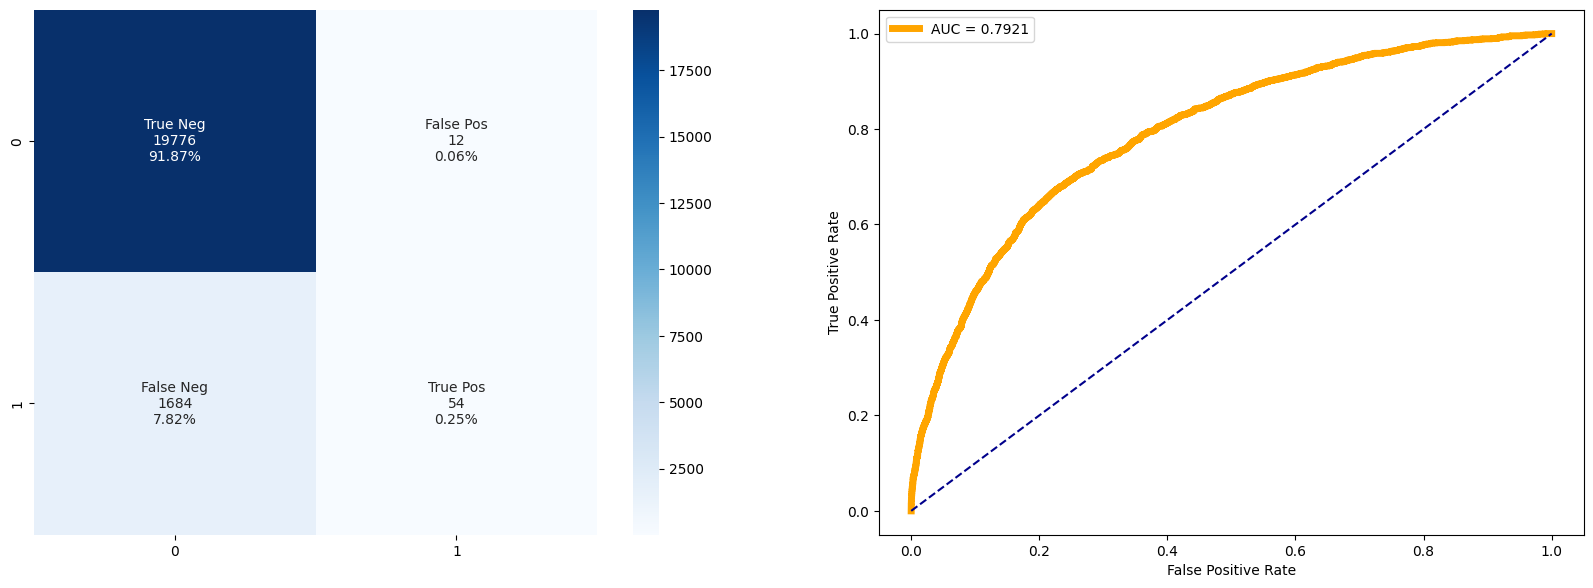

In [15]:
cf_matrix_roc_auc(lgbm_clf_auc, valid_y,lgbm_clf_auc.predict(valid_x), lgbm_clf_auc.predict_proba(valid_x)[:,1])

# 8_ Interpretabilité du modèle de prédiction avec SHAP

## 8_1 Importation du package SHAP

In [16]:
import shap


## 8_2 Création de shapley values

In [17]:
shap_values = shap.TreeExplainer(lgbm_clf_auc).shap_values(valid_x)

## 8_3 Graphiques d'interpretabilité

## 8_4 Graphique global

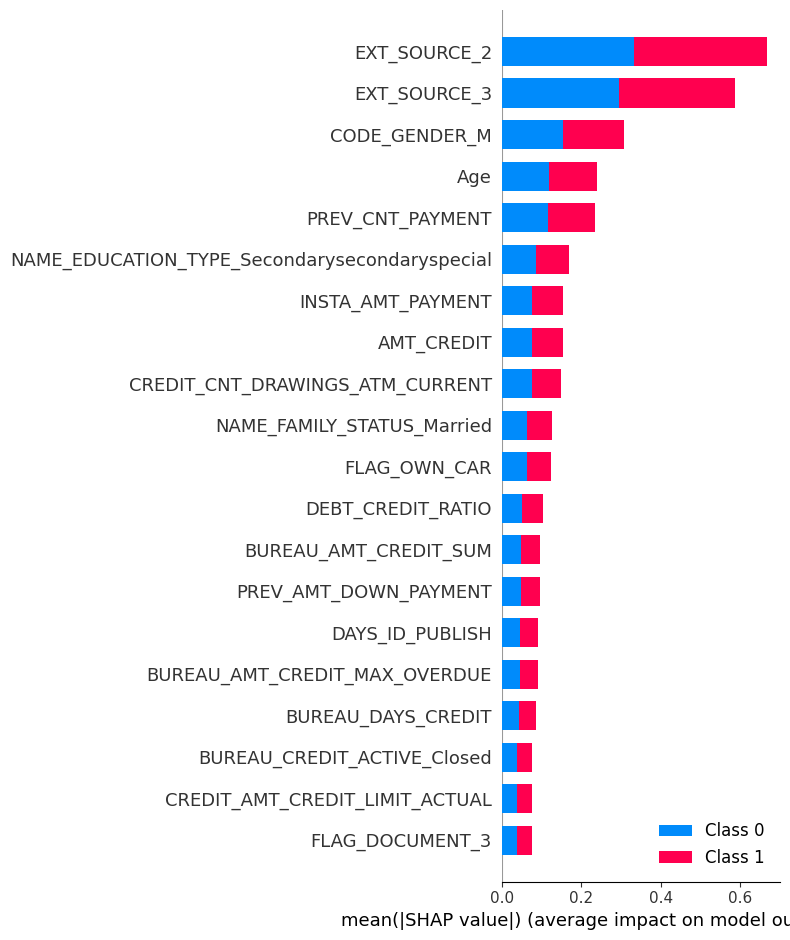

In [18]:
shap.summary_plot(shap_values, valid_x)

# 9_Graphiques locaux avec dépendances

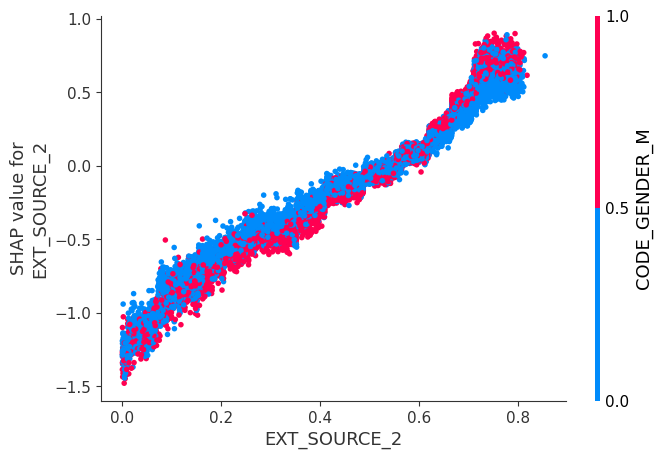

In [19]:
shap.dependence_plot("EXT_SOURCE_2", shap_values[0], valid_x)

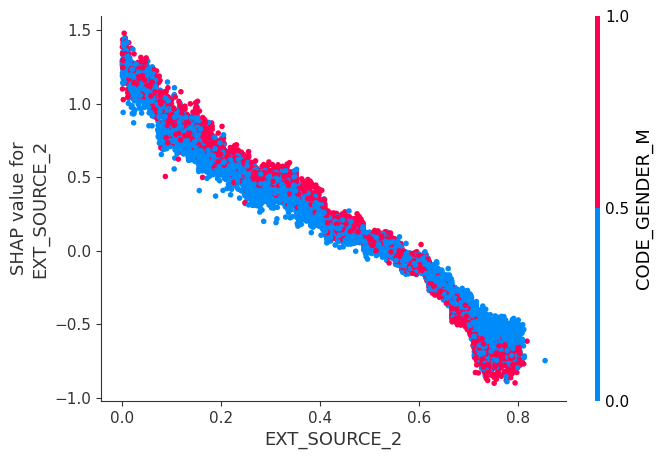

In [20]:
shap.dependence_plot("EXT_SOURCE_2", shap_values[1], valid_x)

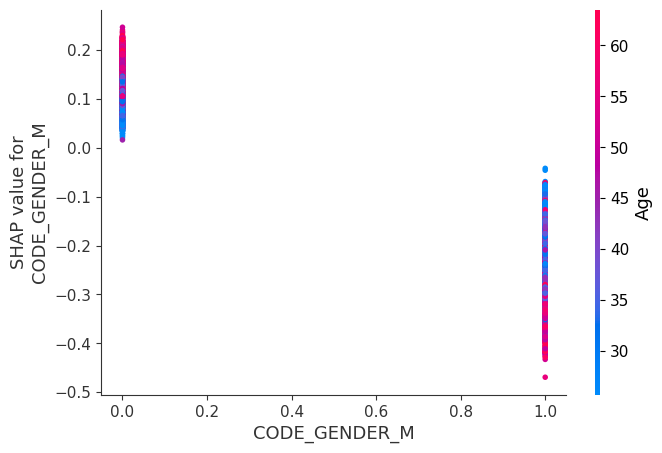

In [21]:
shap.dependence_plot("CODE_GENDER_M", shap_values[0], valid_x)

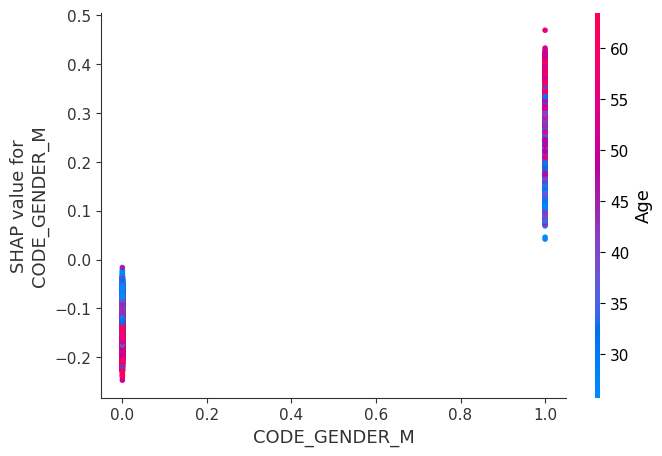

In [22]:
shap.dependence_plot("CODE_GENDER_M", shap_values[1], valid_x)

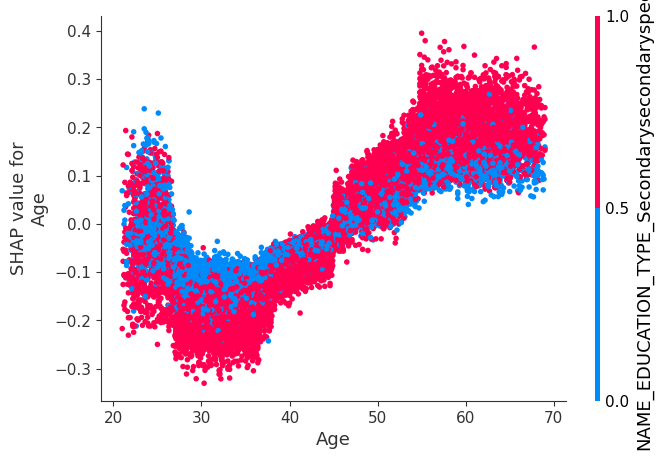

In [23]:
shap.dependence_plot("Age", shap_values[0], valid_x)

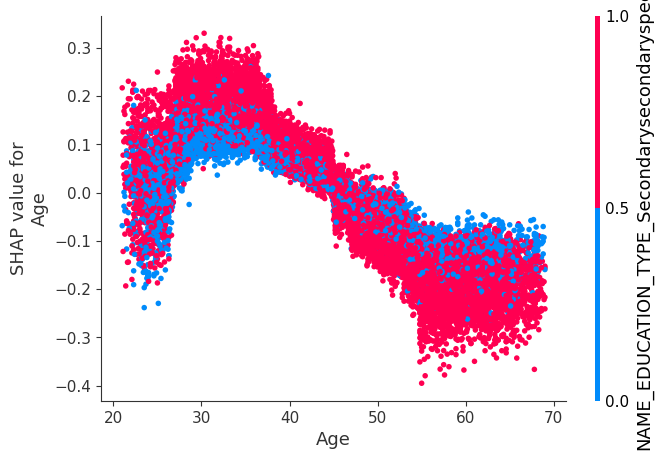

In [24]:
shap.dependence_plot("Age", shap_values[1], valid_x)

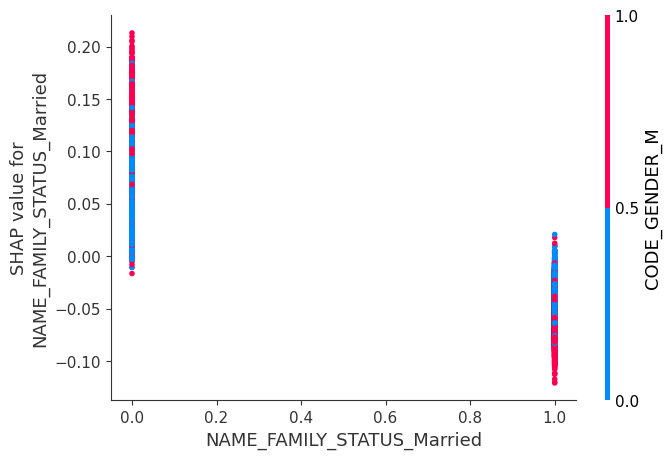

In [25]:
shap.dependence_plot("NAME_FAMILY_STATUS_Married", shap_values[1], valid_x)

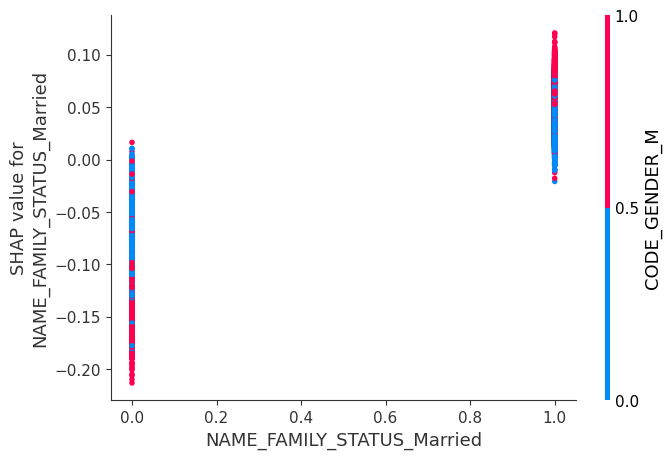

In [26]:
shap.dependence_plot("NAME_FAMILY_STATUS_Married", shap_values[0], valid_x)

# 10 Conception de la mise à jour description des variables à implémenter dans l'application Scoring Client

In [27]:
# Creating the dataframe
data = pd.read_csv("X_data.csv").rename(columns={'Age':'DAYS_BIRTH'})
data

In [29]:
ds_sample=data.sample(10000)
ds_sample

In [31]:
# sort by index labels
data_ski=ds_sample.set_index('SK_ID_CURR').sort_index(axis = 0)

# sorting based on column labels
data_skil=data_ski.sort_index(axis=1)

data_skil.to_csv('data.skill.csv',index=True)
data=pd.read_csv('data.skill.csv')

In [90]:
appli_descriptif=pd.DataFrame(data.columns.values,columns=['Row'])
appli_descriptif.sort_values(by=['Row'])

,Row
1,AMT_CREDIT
2,AMT_INCOME_TOTAL
3,AMT_REQ_CREDIT_BUREAU_QRT
4,AMT_REQ_CREDIT_BUREAU_YEAR
5,BUREAU_AMT_ANNUITY
6,BUREAU_AMT_CREDIT_MAX_OVERDUE
7,BUREAU_AMT_CREDIT_SUM
8,BUREAU_AMT_CREDIT_SUM_DEBT
9,BUREAU_AMT_CREDIT_SUM_LIMIT
10,BUREAU_AMT_CREDIT_SUM_OVERDUE


In [127]:
Old_Descriptif = (pd.read_csv('HomeCredit_columns_description.csv', usecols = ['Row','Description'], encoding='latin'))
Old_Descriptif

,Row,Description
0,SK_ID_CURR,ID of loan in our sample
1,TARGET,"Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)"
2,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving
3,CODE_GENDER,Gender of the client
4,FLAG_OWN_CAR,Flag if the client owns a car
5,FLAG_OWN_REALTY,Flag if client owns a house or flat
6,CNT_CHILDREN,Number of children the client has
7,AMT_INCOME_TOTAL,Income of the client
8,AMT_CREDIT,Credit amount of the loan
9,AMT_ANNUITY,Loan annuity


In [132]:
Matching_Descriptif = appli_descriptif.merge(Old_Descriptif, on="Row",how = 'inner')
Matching_Descriptif.drop_duplicates(inplace=True)
Matching_Descriptif.drop_duplicates(subset='Row', keep="last",inplace=True)
Matching_Descriptif.reset_index(drop=True,inplace=True)
Matching_Descriptif

,Row,Description
0,SK_ID_CURR,"ID of loan in our sample - one loan in our sample can have 0,1,2 or more related previous credits in credit bureau"
1,AMT_CREDIT,"Final credit amount on the previous application. This differs from AMT_APPLICATION in a way that the AMT_APPLICATION is the amount for which the client initially applied for, but during our approval process he could have received different amount - AMT_CREDIT"
2,AMT_INCOME_TOTAL,Income of the client
3,AMT_REQ_CREDIT_BUREAU_QRT,Number of enquiries to Credit Bureau about the client 3 month before application (excluding one month before application)
4,AMT_REQ_CREDIT_BUREAU_YEAR,Number of enquiries to Credit Bureau about the client one day year (excluding last 3 months before application)
5,CNT_CHILDREN,Number of children the client has
6,DAYS_BIRTH,Client's age in days at the time of application
7,DAYS_ID_PUBLISH,How many days before the application did client change the identity document with which he applied for the loan
8,DAYS_LAST_PHONE_CHANGE,How many days before application did client change phone
9,DAYS_REGISTRATION,How many days before the application did client change his registration


In [136]:
list_old_descriptif = [list(Old_Descriptif['Row']),list(Old_Descriptif['Description'])]
list_new_descriptif= [list(Matching_Descriptif['Row']),list(Matching_Descriptif['Description'])]
list_new_row= list(data.columns.values)
tempIte = 0

for index, el in enumerate(list_old_descriptif[0]):
    if not el in list_new_descriptif[0]:
        for newEl in list_new_row:
            if (el in newEl):
                if not newEl in list_new_descriptif[0]:
                    list_new_descriptif[0].append(newEl)
                    list_new_descriptif[1].append(list_old_descriptif[1][index])

for el in list_new_row:
    if not (el in list_new_descriptif[0]):
        list_new_descriptif[0].append(el)
        list_new_descriptif[1].append("NULL")
        

In [138]:
appli_var_descriptif=(pd.DataFrame(list_new_descriptif).transpose()).rename(columns={0:"Variable",1 :"Description"})
appli_var_descriptif.sort_values(by=['Variable'],inplace=True)
appli_var_descriptif.reset_index(drop=True,inplace=True)
appli_var_descriptif

,Variable,Description
0,AMT_CREDIT,"Final credit amount on the previous application. This differs from AMT_APPLICATION in a way that the AMT_APPLICATION is the amount for which the client initially applied for, but during our approval process he could have received different amount - AMT_CREDIT"
1,AMT_INCOME_TOTAL,Income of the client
2,AMT_REQ_CREDIT_BUREAU_QRT,Number of enquiries to Credit Bureau about the client 3 month before application (excluding one month before application)
3,AMT_REQ_CREDIT_BUREAU_YEAR,Number of enquiries to Credit Bureau about the client one day year (excluding last 3 months before application)
4,BUREAU_AMT_ANNUITY,Loan annuity
5,BUREAU_AMT_CREDIT_MAX_OVERDUE,Maximal amount overdue on the Credit Bureau credit so far (at application date of loan in our sample)
6,BUREAU_AMT_CREDIT_SUM,Current credit amount for the Credit Bureau credit
7,BUREAU_AMT_CREDIT_SUM_DEBT,Current credit amount for the Credit Bureau credit
8,BUREAU_AMT_CREDIT_SUM_LIMIT,Current credit amount for the Credit Bureau credit
9,BUREAU_AMT_CREDIT_SUM_OVERDUE,Current credit amount for the Credit Bureau credit


In [140]:
appli_var_descriptif.loc[31,'Description']="ratio of credit amount to total customer revenue "

In [141]:
appli_var_descriptif.loc[36,'Description']="ratio of the total amount of debits in credits to the sum of credits"

In [142]:
appli_var_descriptif.loc[72,'Description']="ratio of the total customer overdue to the total customer debt"

In [143]:
appli_var_descriptif.loc[73,'Description']="Previous amount of credit"

In [144]:
appli_var_descriptif.loc[75,'Description']="Previous applicant count"

In [145]:
appli_var_descriptif

,Variable,Description
0,AMT_CREDIT,"Final credit amount on the previous application. This differs from AMT_APPLICATION in a way that the AMT_APPLICATION is the amount for which the client initially applied for, but during our approval process he could have received different amount - AMT_CREDIT"
1,AMT_INCOME_TOTAL,Income of the client
2,AMT_REQ_CREDIT_BUREAU_QRT,Number of enquiries to Credit Bureau about the client 3 month before application (excluding one month before application)
3,AMT_REQ_CREDIT_BUREAU_YEAR,Number of enquiries to Credit Bureau about the client one day year (excluding last 3 months before application)
4,BUREAU_AMT_ANNUITY,Loan annuity
5,BUREAU_AMT_CREDIT_MAX_OVERDUE,Maximal amount overdue on the Credit Bureau credit so far (at application date of loan in our sample)
6,BUREAU_AMT_CREDIT_SUM,Current credit amount for the Credit Bureau credit
7,BUREAU_AMT_CREDIT_SUM_DEBT,Current credit amount for the Credit Bureau credit
8,BUREAU_AMT_CREDIT_SUM_LIMIT,Current credit amount for the Credit Bureau credit
9,BUREAU_AMT_CREDIT_SUM_OVERDUE,Current credit amount for the Credit Bureau credit


In [148]:
appli_var_descriptif.to_csv('appli_descriptif.csv',index=False)